In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import gym
import argparse 
import time
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [30]:
def weight_init(layers):
    for layer in layers:
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

class DDQN(nn.Module):
    def __init__(self, state_size, action_size,layer_size, n_step, seed, layer_type="ff"):
        super(DDQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_shape = state_size
        self.action_size = action_size
        self.state_dim = len(state_size)
        self.layer_size = layer_size
        if self.state_dim == 3:
            self.cnn_1 = nn.Conv2d(4, out_channels=32, kernel_size=8, stride=4)
            self.cnn_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
            self.cnn_3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
            weight_init([self.cnn_1, self.cnn_2, self.cnn_3])

            if layer_type == "noisy":
                self.ff_1 = NoisyLinear(self.calc_input_layer(), layer_size)
                self.ff_2 = NoisyLinear(layer_size, action_size)
            else:
                self.ff_1 = nn.Linear(self.calc_input_layer(), layer_size)
                self.ff_2 = nn.Linear(layer_size, action_size)
                weight_init([self.ff_1])
        elif self.state_dim == 1:
            if layer_type == "noisy":
                self.head_1 = NoisyLinear(self.input_shape[0], layer_size)
                self.ff_1 = NoisyLinear(layer_size, layer_size)
                self.ff_2 = NoisyLinear(layer_size, action_size)
            else:
                self.head_1 = nn.Linear(self.input_shape[0], layer_size)
                self.ff_1 = nn.LSTM(layer_size, layer_size) #,2
                self.ff_2 = nn.Linear(layer_size, layer_size)
                self.ff_3 = nn.Linear(layer_size, action_size)
                weight_init([self.head_1])
        else:
            print("Unknown input dimension!")


        
    def calc_input_layer(self):
        x = torch.zeros(self.input_shape).unsqueeze(0)
        x = self.cnn_1(x)
        x = self.cnn_2(x)
        x = self.cnn_3(x)
        return x.flatten().shape[0]
    
    def forward(self, input, hidden_state):
        """
        
        """

        input.unsqueeze_(0)
        if self.state_dim == 3:
            x = torch.relu(self.cnn_1(input))
            x = torch.relu(self.cnn_2(x))
            x = torch.relu(self.cnn_3(x))
            x = x.view(input.size(0), -1)
        else:
            x = torch.relu(self.head_1(input))
        
        #x = x.unsqueeze(1)
        x, hidden_out = self.ff_1(x, hidden_state)
        x = torch.relu(self.ff_2(x))
        out = self.ff_3(x)
        return out[0], hidden_out

In [124]:
class LSTM_ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.sequence_size = batch_size
        
        self.experience = deque(maxlen=buffer_size)
        self.seed = random.seed(seed)
        self.episode_buffer = []
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""

        
        self.episode_buffer.append((state, action, reward, next_state, done))
        if done == True:
            self.experience.append(np.vstack(self.episode_buffer))
            self.episode_buffer = []        
    
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        episode = random.sample(self.experience, k=1)
        episode = episode[0]
        ep_len = len(episode)
        end = max(ep_len-self.sequence_size, 1)
        seq_start = np.random.randint(0, end)
        experiences = episode[seq_start:seq_start+self.sequence_size]
        #print(experiences)
        
        states = torch.from_numpy(np.stack([e[0] for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e[3] for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.experience)

In [143]:
class DQN_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self,
                 state_size,
                 action_size,
                 Network,
                 layer_size,
                 n_step,
                 BATCH_SIZE,
                 BUFFER_SIZE,
                 LR,
                 TAU,
                 GAMMA,
                 UPDATE_EVERY,
                 device,
                 seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            Network (str): dqn network type
            layer_size (int): size of the hidden layer
            BATCH_SIZE (int): size of the training batch
            BUFFER_SIZE (int): size of the replay memory
            LR (float): learning rate
            TAU (float): tau for soft updating the network weights
            GAMMA (float): discount factor
            UPDATE_EVERY (int): update frequency
            device (str): device that is used for the compute
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.TAU = TAU
        self.GAMMA = GAMMA
        self.UPDATE_EVERY = UPDATE_EVERY
        self.BATCH_SIZE = BATCH_SIZE
        self.Q_updates = 0
        self.n_step = n_step
        self.update_steps = 0
    
        self.action_step = 4
        self.last_action = None
        self.hidden_state = None



        self.qnetwork_local = DDQN(state_size, action_size,layer_size, n_step, seed).to(device)
        self.qnetwork_target = DDQN(state_size, action_size,layer_size, n_step, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)#, alpha=0.95, eps=0.01)
        print(self.qnetwork_local)
        
        # Replay memory
        self.memory = LSTM_ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, self.device, seed)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done, writer):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.BATCH_SIZE:
                updates = 0
                #several random updates
                #while updates < self.BATCH_SIZE:
                for i in range(1):
                    experiences = self.memory.sample()
                    loss, state_len = self.learn(experiences)
                    #print(state_len)
                #    updates += state_len
                self.Q_updates += 1
                writer.add_scalar("Q_loss", loss, self.Q_updates)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy. Acting only every 4 frames!
        
        Params
        ======
            frame: to adjust epsilon
            state (array_like): current state
            
        """

        if self.action_step == 4:
            state = np.array(state)

            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values, hidden = self.qnetwork_local(state, self.hidden_state)
                self.hidden_state = hidden
            self.qnetwork_local.train()

            # Epsilon-greedy action selection
            if random.random() > eps: # select greedy action if random number is higher than epsilon or noisy network is used!
                action = np.argmax(action_values.cpu().data.numpy())
                self.last_action = action
                #print("greedy: ", action)
                return action
            else:
                action = random.choice(np.arange(self.action_size))
                self.last_action = action 
                #print("random: ", action)
                return action
            #self.action_step = 0
        else:
            self.action_step += 1
            return self.last_action

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        update_losses = []
        #while self.update_steps <= 4:
        states, actions, rewards, next_states, dones = experiences

        #print(next_states.shape)
        hidden_state = None
        hidden_2 = None
        state_len = len(states)
        for i in range(state_len):
            self.optimizer.zero_grad()
            # Get max predicted Q values (for next states) from target model
            Q_targets_next, hidden_2 = self.qnetwork_target.forward(next_states[i].unsqueeze_(0), hidden_2)
            hidden_2 = (hidden_2[0].data,hidden_2[1].data)
            Q_targets_next = Q_targets_next.detach().max(1)[0]
            # Compute Q targets for current states 
            Q_targets = rewards[i] + (self.GAMMA**self.n_step * Q_targets_next * (1 - dones[i]))
            # Get expected Q values from local model
            Q_expected, hidden_state = self.qnetwork_local(states[i].unsqueeze_(0), hidden_state) 
            hidden_state = (hidden_state[0].detach(),hidden_state[1].detach())
            Q_expected = Q_expected.gather(1, actions[i].unsqueeze_(0))             
            # Compute loss
            loss = F.mse_loss(Q_expected.squeeze(0), Q_targets)
            # Minimize the loss
            loss.backward(retain_graph=True) 
            clip_grad_norm_(self.qnetwork_local.parameters(),1)
            self.optimizer.step()
            update_losses.append(loss.detach().cpu().numpy())

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target)
        
        
        return np.mean(update_losses), state_len         

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.TAU*local_param.data + (1.0-self.TAU)*target_param.data)

In [144]:
writer = SummaryWriter("runs/"+"testrun")

BUFFER_SIZE = 1000
BATCH_SIZE = 8
GAMMA = 0.99
TAU = 1e-3
LR = 1e-3
UPDATE_EVERY = 1
n_step = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)

seed = 1

env = gym.make("CartPole-v0")
env.seed(seed)
np.random.seed(seed)
action_size     = env.action_space.n
state_size = env.observation_space.shape


agent = DQN_Agent(state_size=state_size,    
                action_size=action_size,
                Network="dqn",
                layer_size=512,
                n_step=n_step,
                BATCH_SIZE=BATCH_SIZE, 
                BUFFER_SIZE=BUFFER_SIZE, 
                LR=LR, 
                TAU=TAU, 
                GAMMA=GAMMA, 
                UPDATE_EVERY=UPDATE_EVERY, 
                device=device, 
                seed=seed)

Using  cuda:0
DDQN(
  (head_1): Linear(in_features=4, out_features=512, bias=True)
  (ff_1): LSTM(512, 512)
  (ff_2): Linear(in_features=512, out_features=512, bias=True)
  (ff_3): Linear(in_features=512, out_features=2, bias=True)
)


In [145]:
def run(frames=1000, eps_frames=1e6, min_eps=0.01):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    frame = 0
    eps = 1
    eps_start = 1
    i_episode = 1
    state = env.reset()
    score = 0            
    for frame in range(1, frames+1):

        action = agent.act(state, eps)
        #print(action)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done, writer)
        state = next_state
        score += reward
        # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training

        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)

        if done:
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            writer.add_scalar("Epsilon", eps, i_episode)
            writer.add_scalar("Reward", score, i_episode)
            writer.add_scalar("Average100", np.mean(scores_window), i_episode)
            print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tFrame {}\tAverage Score: {:.2f}'.format(i_episode,frame, np.mean(scores_window)))
            i_episode +=1 
            state = env.reset()
            score = 0              

    return scores

In [146]:
%time
history = run(frames = 10000, eps_frames=1000, min_eps=0.01)


CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 17.2 µs
Episode 100	Frame 1435	Average Score: 14.355
Episode 200	Frame 3453	Average Score: 20.188
Episode 300	Frame 5571	Average Score: 21.188
Episode 400	Frame 6744	Average Score: 11.733
Episode 500	Frame 8147	Average Score: 14.033
Episode 600	Frame 9919	Average Score: 17.722
Episode 603	Frame 9986 	Average Score: 17.83

In [96]:
a = torch.zeros((8,1))

In [98]:
a[0].unsqueeze(0)

tensor([[0.]])

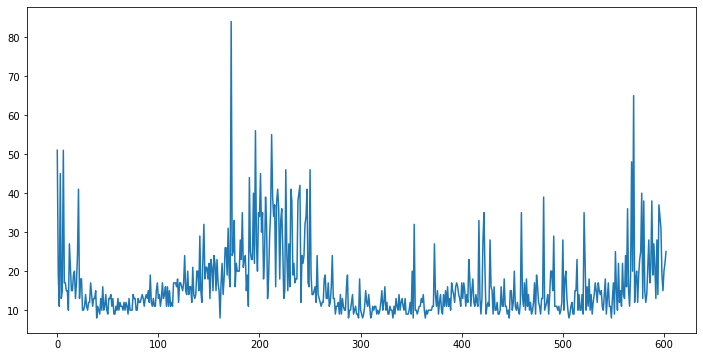

In [147]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(history)
plt.show()

# Testing

In [150]:
for i in range(10):
    state = env.reset()
    scores = 0
    while True:
        env.render()
        action = agent.act(state, 0)
        #print(action)
        state, reward, done, _ = env.step(action)
        #print("step")
        scores += reward
        if done:
            #print("over")
            break
    print("Episode {} | Score {}".format(i, scores))
env.close()        

Episode 0 | Score 10.0
Episode 1 | Score 9.0
Episode 2 | Score 9.0
Episode 3 | Score 9.0
Episode 4 | Score 10.0
Episode 5 | Score 9.0
Episode 6 | Score 9.0
Episode 7 | Score 8.0
Episode 8 | Score 9.0
Episode 9 | Score 10.0


In [46]:
ex = agent.memory.sample()

51


In [47]:
ex

(tensor([[-0.0343, -0.5793,  0.0395,  0.7456]], device='cuda:0'),
 tensor([[1]], device='cuda:0'),
 tensor([[1.]], device='cuda:0'),
 tensor([[-0.0459, -0.3848,  0.0544,  0.4656]], device='cuda:0'),
 tensor([[0.]], device='cuda:0'))